<a href="https://colab.research.google.com/github/SilahicAmil/NLP-NLTK/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sentiment Analysis 

Sentiment analysis on the IMBD dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import shutil

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

## Dataset import

In [2]:


url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1",
                                  url,
                                  untar=True,
                                  cache_dir=".",
                                  cache_subdir="")


dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

In [3]:
os.listdir(dataset_dir)

['README', 'imdb.vocab', 'train', 'imdbEr.txt', 'test']

In [4]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['neg',
 'urls_unsup.txt',
 'pos',
 'unsup',
 'urls_neg.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsupBow.feat']

In [5]:
sample_file = os.path.join(train_dir, "pos/1181_9.txt")
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Loading the dataset and some preprocessing

In [6]:
# removing irrelevant folder
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [7]:
# Creating validation set
# text_dataset_from_directory creates a labeled td.data.Datset

batch_size = 32
seed = 42

train_set = tf.keras.utils.text_dataset_from_directory("aclImdb/train",
                                                       batch_size=batch_size,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Originally 25k examples in the training folder which now 80% will be used for training and the other 5k for validation.

In [8]:
# Prinitng out examples
for text_batch, label_batch in train_set.take(1):
  for i in range(5):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In the the reviews there is raw text and the occasional HTML tags. Let's see how we can handle these.

Labels 0 or 1 correspond to pos or neg movie reviews.

0- neg

1- pos

which we can see is confirmed below

In [9]:
print('Label 0 is', train_set.class_names[0])
print('Label 1 is', train_set.class_names[1])

Label 0 is neg
Label 1 is pos


## Creating Test and Validation dataset

In [10]:
# Validation set
val_set = tf.keras.utils.text_dataset_from_directory("aclImdb/train",
                                                     batch_size=batch_size,
                                                     validation_split=0.2,
                                                     subset="validation",
                                                     seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
# Test set

test_set = tf.keras.utils.text_dataset_from_directory("aclImdb/test",
                                                      batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Preparing dataset for training

Standardizing, tokenizing and vectorizing the datasets with tf.keras.layers.TextVectorization.

Standardization refers to making the making the dataset to simplify it. Removing punctuation, HTML elements and etc.

Tokenization is splitting string to tokens. Example: splitting a sentence into individual words by splitting on the white space.

Vectorization is converting tokens into numbers so they can be used in a nueral net for learning.

In [12]:
# Standardizing dataset

def standardize_datasets(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

  return tf.strings.regex_replace(stripped_html,
                                 '[%s]' % re.escape(string.punctuation),
                                 '')

In [13]:
# TextVectorization layer does everything. Standardizes, tokenize and vectorize
MAX_FEATS = 10000
SEQUENCE_LEN = 250

vectorization_layer = layers.TextVectorization(
    standardize=standardize_datasets,
    max_tokens=MAX_FEATS,
    output_mode="int", # creates unique int for each token
    output_sequence_length=SEQUENCE_LEN)

Note: When using .adapt() only use it on the trainin data

In [14]:
# Text only dataset, no labels
train_text_set = train_set.map(lambda x, y: x)
vectorization_layer.adapt(train_text_set)

In [15]:
# Function to see results of the layer
def vect_text(text, label):
  text = tf.expand_dims(text, -1)
  
  return vectorization_layer(text), label

In [16]:
# Review batch from the dataset

text_batch, label_batch = next(iter(train_set))
first_review, first_label = text_batch[0], label_batch[0]

print(f"First Review: {first_review}\nFirst Label {train_set.class_names[first_label]}\nVectorized Review: {vect_text(first_review, first_label)}")

First Review: b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.'
First Label neg
Vectorized Review: (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   

WE can see each token is an integer. Let's see what token corresponds to what integer

In [17]:
print(f"1337 -> {vectorization_layer.get_vocabulary()[1337]}\n420 -> {vectorization_layer.get_vocabulary()[420]}\nVocab Size: {len(vectorization_layer.get_vocabulary())}")

1337 -> sent
420 -> yes
Vocab Size: 10000


## Applying TextVectorization to train, val and test sets

In [18]:
# Vectorizing Text
train_set = train_set.map(vect_text)
test_set = test_set.map(vect_text)
val_set = val_set.map(vect_text)

## Creating a perfomant dataset

using .cache() and .prefetch() from tf.data.Datset

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)
val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)

## Model Creation Time

using the TF sequential API

Topology of the model:

First Layer is the embedding layer. This takes the int encoded reviews and looks up the embedding vector for each word index. The vectors are learned as the model trains. Vectors add a dimension to the output. So the dimensions look like `(batch, sequence, embedding)`.

Then we dropout to avoid overfitting

Next we use the GlobalAveragePooling1D to return a fixed output length vector.  Which averages over the sequence dimension. This lets the model handle intput of varying lengths.

The last layer is a dense layer with a single output



In [25]:
EMBEDDING_DIMS = 16

model_1 = tf.keras.Sequential([
      layers.Embedding(MAX_FEATS +1, EMBEDDING_DIMS),
      layers.Dropout(0.2),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.2),
      layers.Dense(1) 
                              
])

In [27]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

## Loss Function and optimizer

Since this is a binary classifier (0 or 1) we use the BinaryCrossentropy loss func

In [31]:
# Compiling the model
model_1.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                optimizer="adam",
                metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [32]:
# Trainig the model
%%time

hist_1 = model_1.fit(train_set,
                     validation_data=val_set,
                     epochs=10)

Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5620 - binary_accuracy: 0.7955 - val_loss: 0.5201 - val_binary_accuracy: 0.8160
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4679 - binary_accuracy: 0.8376 - val_loss: 0.4403 - val_binary_accuracy: 0.8420
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3967 - binary_accuracy: 0.8598 - val_loss: 0.3874 - val_binary_accuracy: 0.8566
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3487 - binary_accuracy: 0.8744 - val_loss: 0.3546 - val_binary_accuracy: 0.8650
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3159 - binary_accuracy: 0.8853 - val_loss: 0.3323 - val_binary_accuracy: 0.8696
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2898 - binary_accuracy: 0.8946 - val_loss: 0.3170 - val_binary_accuracy: 0.8738
Epoch 7/10
625/625 [==============================] - 5s 8ms/ste

## Evaluating the model

In [34]:
loss, accuracy = model_1.evaluate(test_set)

print(f"Loss: {loss}\nAccuracy: {accuracy}")

782/782 [==============================] - 9s 11ms/step - loss: 0.3089 - binary_accuracy: 0.8741
Loss: 0.30891555547714233
Accuracy: 0.8740800023078918


Even though the model is very naive it achieves an accuracy of 87%

## Plotting accuracy and loss over time

In [35]:
hist_dict_1 = hist_1.history
hist_dict_1.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are 4 entries which is 1 for each monitored metrics during traning and validation. Lets plot these and see how it converges

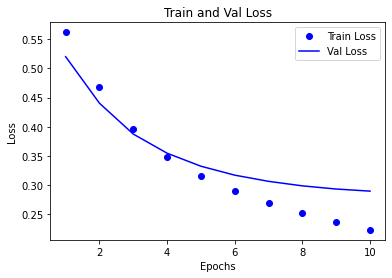

In [38]:
# Validation and Training loss plot
acc = hist_dict_1["binary_accuracy"]
val_acc = hist_dict_1["val_binary_accuracy"]
loss = hist_dict_1["loss"]
val_loss = hist_dict_1["val_loss"]

epochs = range(1, len(acc) +1)

plt.plot(epochs, loss, "bo", label="Train Loss")
plt.plot(epochs, val_loss, "b", label="Val Loss")
plt.title("Train and Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

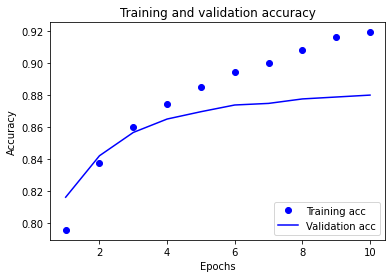

In [39]:
# Accuracy over epochs plot
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Testing out another model

In [40]:
#model_1 = tf.keras.Sequential([
 #     layers.Embedding(MAX_FEATS +1, EMBEDDING_DIMS),
  #    layers.Dropout(0.2),
   #   layers.GlobalAveragePooling1D(),
    #  layers.Dropout(0.2),
     # layers.Dense(1) 
                              
#])

In [69]:
model_2 = tf.keras.Sequential([
      layers.Embedding(MAX_FEATS +1, EMBEDDING_DIMS),
      layers.Dropout(0.2),
      layers.Conv1D(32, kernel_size=5, padding="same", activation="relu"),
      layers.Dropout(0.2),
      layers.Conv1D(16, kernel_size=5, activation="relu"),
      layers.GlobalAveragePooling1D(),
      layers.Dropout(0.2),
      layers.Dense(1) 
                              
])

In [70]:
model_2.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                optimizer="adam",
                metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [71]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [72]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_16 (Dropout)        (None, None, 16)          0         
                                                                 
 conv1d_10 (Conv1D)          (None, None, 32)          2592      
                                                                 
 dropout_17 (Dropout)        (None, None, 32)          0         
                                                                 
 conv1d_11 (Conv1D)          (None, None, 16)          2576      
                                                                 
 global_average_pooling1d_8   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                      

In [73]:
#Training model 2
%%time
hist_model_2 = model_2.fit(train_set,
                           epochs=10,
                           validation_data=val_set)

Epoch 1/10
625/625 [==============================] - 20s 31ms/step - loss: 0.4737 - binary_accuracy: 0.7501 - val_loss: 0.3218 - val_binary_accuracy: 0.8720
Epoch 2/10
625/625 [==============================] - 19s 31ms/step - loss: 0.2795 - binary_accuracy: 0.8892 - val_loss: 0.2935 - val_binary_accuracy: 0.8836
Epoch 3/10
625/625 [==============================] - 20s 32ms/step - loss: 0.2186 - binary_accuracy: 0.9173 - val_loss: 0.2871 - val_binary_accuracy: 0.8882
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 0.1800 - binary_accuracy: 0.9326 - val_loss: 0.2994 - val_binary_accuracy: 0.8878
Epoch 5/10
625/625 [==============================] - 20s 32ms/step - loss: 0.1617 - binary_accuracy: 0.9395 - val_loss: 0.3158 - val_binary_accuracy: 0.8844
Epoch 6/10
625/625 [==============================] - 21s 33ms/step - loss: 0.1326 - binary_accuracy: 0.9507 - val_loss: 0.3512 - val_binary_accuracy: 0.8780
Epoch 7/10
625/625 [==============================] 

In [74]:
loss, accuracy = model_2.evaluate(test_set)

print(f"Loss: {loss}\nAccuracy: {accuracy}")

782/782 [==============================] - 6s 8ms/step - loss: 0.5563 - binary_accuracy: 0.8470
Loss: 0.556270182132721
Accuracy: 0.8470399975776672


Even thought we added more deep learning layers. It has an accuracy of 85%. Less than the naive baseline. As we know trying to imporve upon the baseline is very hard. Lets see if we can create some better models

## More model testing